In [1]:
from torch.utils.data import DataLoader
from datasets.Dataset_Dipole_H import Dataset_Dipole_H
from models.UNet import UNet
from training.Trainer_Dipole_H import Trainer_Dipole_H
import torch
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
# dataset parameters
dataset_path = "../data/raw/npz_select_1cmSpacing"
mdfile = "md_hshaped_v1"
maximum_elements = 19200
# maximum_elements = 2560
traintestsplit = 0.1

# hyperparameters
batch_size = 64
# batch_size = 8
learning_rate = 0.001
num_epochs = 150
depth = 5
wf = 4
padding = True
up_mode = 'upconv'
drop_out = 0

# load dataset
# dataset = Dataset_Dipole_H(dataset_path, maximum_elements=maximum_elements, mdfile=mdfile, prepareFolder="prepared_v1_weighted_o1")
dataset = Dataset_Dipole_H(dataset_path, maximum_elements=maximum_elements, mdfile=mdfile, prepareFolder="prepared")
print("Dataset loaded")
# dataset.prepare_all(overwrite=True)
# print("Dataset prepared")


Dataset loaded


In [3]:

# split dataset into train and test
train_dataset, test_dataset = torch.utils.data.Subset(dataset, range(0, int(len(dataset)*(1-traintestsplit)))), torch.utils.data.Subset(dataset, range(int(len(dataset)*(1-traintestsplit)), len(dataset)))
# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - int(len(dataset)*traintestsplit), int(len(dataset)*traintestsplit)])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(len(train_loader))
print(len(test_loader))

# set device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Using", device)

# load model
model = UNet(in_channels=18, out_channels=2, depth=depth, wf=wf, padding=padding, batch_norm=True, up_mode=up_mode, drop_out=drop_out)
print(model)

# set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(optimizer)

# set criterion
criterion = torch.nn.MSELoss()
print(criterion)

# create trainer
trainer = Trainer_Dipole_H(model, optimizer, criterion, device)
print("Trainer created")

# load model
trainer.load_model("../UNet_Dipole_H.pt")
# trainer.load_model("../models_trained/model_UNet_outer0/UNet_Dipole_H.pt")
print("Model loaded")


270
30
Using mps
UNet(
  (down_path): ModuleList(
    (0): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(18, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): LeakyReLU(negative_slope=0.01)
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): LeakyReLU(negative_slope=0.01)
        (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=Tr

In [4]:
# model.load_state_dict(torch.load("../models_trained/model_UNet_outer0/UNet_Dipole_H.pt"))
model.eval()

UNet(
  (down_path): ModuleList(
    (0): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(18, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): LeakyReLU(negative_slope=0.01)
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): LeakyReLU(negative_slope=0.01)
        (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running

torch.Size([64, 2, 224, 160])
torch.Size([64, 2, 224, 160])
torch.Size([64, 18, 224, 160])


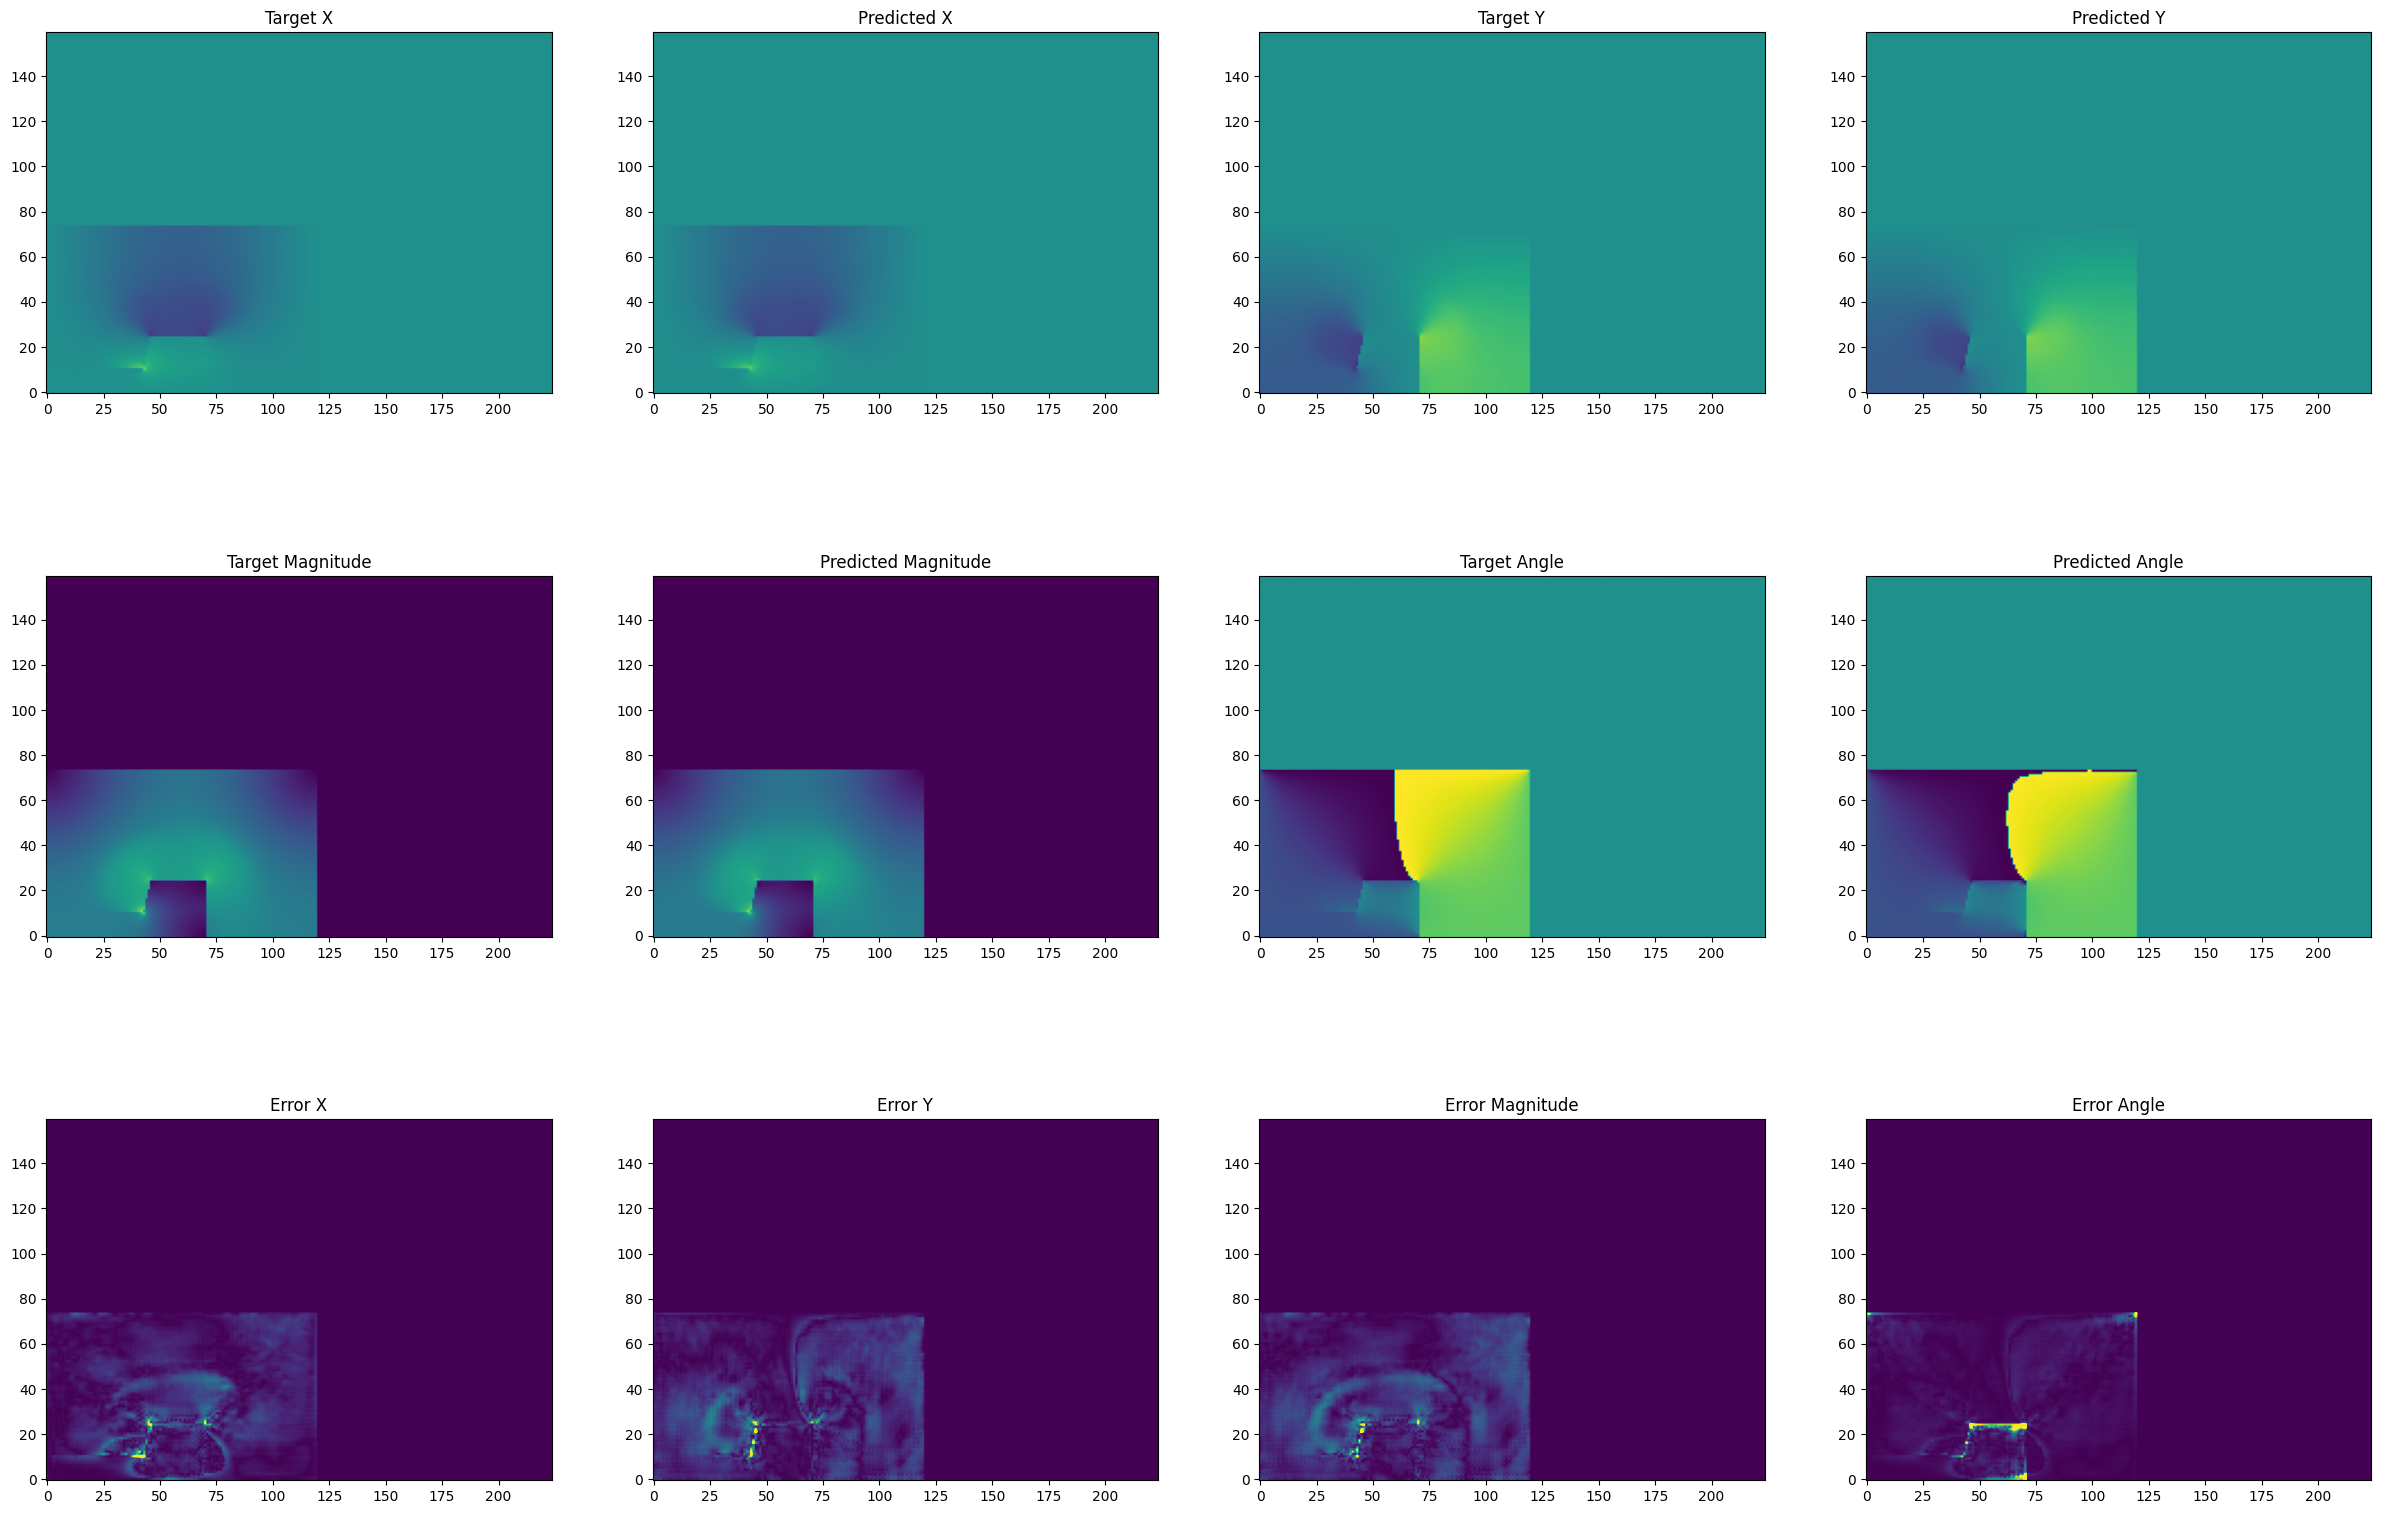

In [26]:
# test model
for i, (x, y) in enumerate(test_loader):
    
    if i == 8:
        sample = 28
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)
        with torch.no_grad():
            y_pred = model(x)
        print(y_pred.shape)
        print(y.shape)
        print(x.shape)
        prio = x[sample, 17, :, :].cpu().detach().numpy().T
        tar_x = y[sample, 0, :, :].cpu().detach().numpy().T
        tar_y = y[sample, 1, :, :].cpu().detach().numpy().T
        pred_x = y_pred[sample, 0, :, :].cpu().detach().numpy().T
        pred_y = y_pred[sample, 1, :, :].cpu().detach().numpy().T
        boolprio = prio > 0

        tar_x = tar_x * boolprio
        tar_y = tar_y * boolprio
        pred_x = pred_x * boolprio
        pred_y = pred_y * boolprio

        # interpret x and y as strength for a vector field in x and y direction - calculate the magnitude and the angle
        tar_mag = np.sqrt(tar_x**2 + tar_y**2)
        tar_ang = np.arctan2(tar_y, tar_x) * boolprio
        pred_mag = np.sqrt(pred_x**2 + pred_y**2)
        pred_ang = np.arctan2(pred_y, pred_x) * boolprio

        # calculate the error
        error_x = np.abs(tar_x - pred_x)
        error_y = np.abs(tar_y - pred_y)
        error_mag = np.abs(tar_mag - pred_mag)
        error_ang = np.abs(np.mod(tar_ang - pred_ang + np.pi, 2*np.pi) - np.pi)

        fig, ax = plt.subplots(3, 4, figsize=(30, 20))
        ax[0, 0].imshow(tar_x, origin='lower', vmin=-2, vmax=2)
        ax[0, 0].set_title("Target X")
        ax[0, 1].imshow(pred_x, origin='lower', vmin=-2, vmax=2)
        ax[0, 1].set_title("Predicted X")
        ax[0, 2].imshow(tar_y, origin='lower', vmin=-2, vmax=2)
        ax[0, 2].set_title("Target Y")
        ax[0, 3].imshow(pred_y, origin='lower', vmin=-2, vmax=2)
        ax[0, 3].set_title("Predicted Y")
        ax[1, 0].imshow(tar_mag, origin='lower', vmin=0, vmax=2)
        ax[1, 0].set_title("Target Magnitude")
        ax[1, 1].imshow(pred_mag, origin='lower', vmin=0, vmax=2)
        ax[1, 1].set_title("Predicted Magnitude")
        ax[1, 2].imshow(tar_ang, origin='lower', vmin=-np.pi, vmax=np.pi)
        ax[1, 2].set_title("Target Angle")
        ax[1, 3].imshow(pred_ang, origin='lower', vmin=-np.pi, vmax=np.pi)
        ax[1, 3].set_title("Predicted Angle")
        ax[2, 0].imshow(error_x, origin='lower', vmin=0, vmax=0.1)
        ax[2, 0].set_title("Error X")
        ax[2, 1].imshow(error_y, origin='lower', vmin=0, vmax=0.1)
        ax[2, 1].set_title("Error Y")
        ax[2, 2].imshow(error_mag, origin='lower', vmin=0, vmax=0.1)
        ax[2, 2].set_title("Error Magnitude")
        ax[2, 3].imshow(error_ang, origin='lower', vmin=0, vmax=0.1*np.pi)
        ax[2, 3].set_title("Error Angle")
        plt.show()
        break

In [6]:
def get_errors(model, test_loader, figureOfMerit="all"):
    if figureOfMerit == "all":
        cl = None
    elif figureOfMerit == "aperture":
        cl = 10
    elif figureOfMerit == "magnet":
        cl = 3
    elif figureOfMerit == "outer":
        cl = 1
    else:
        raise ValueError("Unknown figure of merit")
    # create a histogram that shows the mean error for each sample
    error_x = []
    error_y = []
    error_mag = []
    error_ang = []
    for i, (x, y) in enumerate(test_loader):
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)
        for sample in range(x.shape[0]):
            with torch.no_grad():
                y_pred = model(x)
            tar_x = y[sample, 0, :, :].cpu().detach().numpy().T
            tar_y = y[sample, 1, :, :].cpu().detach().numpy().T
            pred_x = y_pred[sample, 0, :, :].cpu().detach().numpy().T
            pred_y = y_pred[sample, 1, :, :].cpu().detach().numpy().T
            if cl is not None:
                mask = x[sample, 4, :, :] == cl
                mask = mask.cpu().detach().numpy().T
            else:
                mask = None
            err_x = np.abs(tar_x - pred_x)
            err_y = np.abs(tar_y - pred_y)
            err_mag = np.abs(np.sqrt(tar_x**2 + tar_y**2) - np.sqrt(pred_x**2 + pred_y**2))
            err_ang = np.abs(((np.arctan2(tar_y, tar_x) - np.arctan2(pred_y, pred_x)) + np.pi) % (2*np.pi) - np.pi)
            error_x.append(np.mean(np.ma.masked_array(err_x, mask=mask)))
            error_y.append(np.mean(np.ma.masked_array(err_y, mask=mask)))
            error_mag.append(np.mean(np.ma.masked_array(err_mag, mask=mask)))
            error_ang.append(np.mean(np.ma.masked_array(err_ang, mask=mask)))
    error_x = np.array(error_x)
    error_y = np.array(error_y)
    error_mag = np.array(error_mag)
    error_ang = np.array(error_ang)
    return error_x, error_y, error_mag, error_ang



In [7]:
def plot_histogram(ax, data, title, bins, range):
    ax.set_xlim(range)
    counts, bin_edges = np.histogram(data, bins=bins, range=range)
    ax.set_title(title)
    ax.set_xlabel("Mean Error")
    ax.set_ylabel("Frequency")
    ax.set_yscale("log")
    bin_centres = (bin_edges[:-1] + bin_edges[1:]) * 0.5
    err = np.sqrt(counts)
    ax.errorbar(bin_centres, counts, yerr=err, fmt='o')

def plot_histograms(error_x, error_y, error_mag, error_ang):
    fig, ax = plt.subplots(2, 2, figsize=(30, 10))
    plot_histogram(ax[0, 0], error_x, "Error X", 100, (0, 0.5))
    plot_histogram(ax[0, 1], error_y, "Error Y", 100, (0, 0.5))
    plot_histogram(ax[1, 0], error_mag, "Error Magnitude", 100, (0, 0.5))
    plot_histogram(ax[1, 1], error_ang, "Error Angle", 180, (0, np.pi))
    plt.show()

def getErrorHistograms(model, test_loader, figureOfMerit="all"):
    error_x, error_y, error_mag, error_ang = get_errors(model, test_loader, figureOfMerit)
    plot_histograms(error_x, error_y, error_mag, error_ang)
    print("Mean error x:", np.mean(error_x))
    print("Mean error y:", np.mean(error_y))
    print("Mean error magnitude:", np.mean(error_mag))
    print("Mean error angle:", np.mean(error_ang))
    print("Mean error x std:", np.std(error_x))
    print("Mean error y std:", np.std(error_y))
    print("Mean error magnitude std:", np.std(error_mag))
    print("Mean error angle std:", np.std(error_ang))


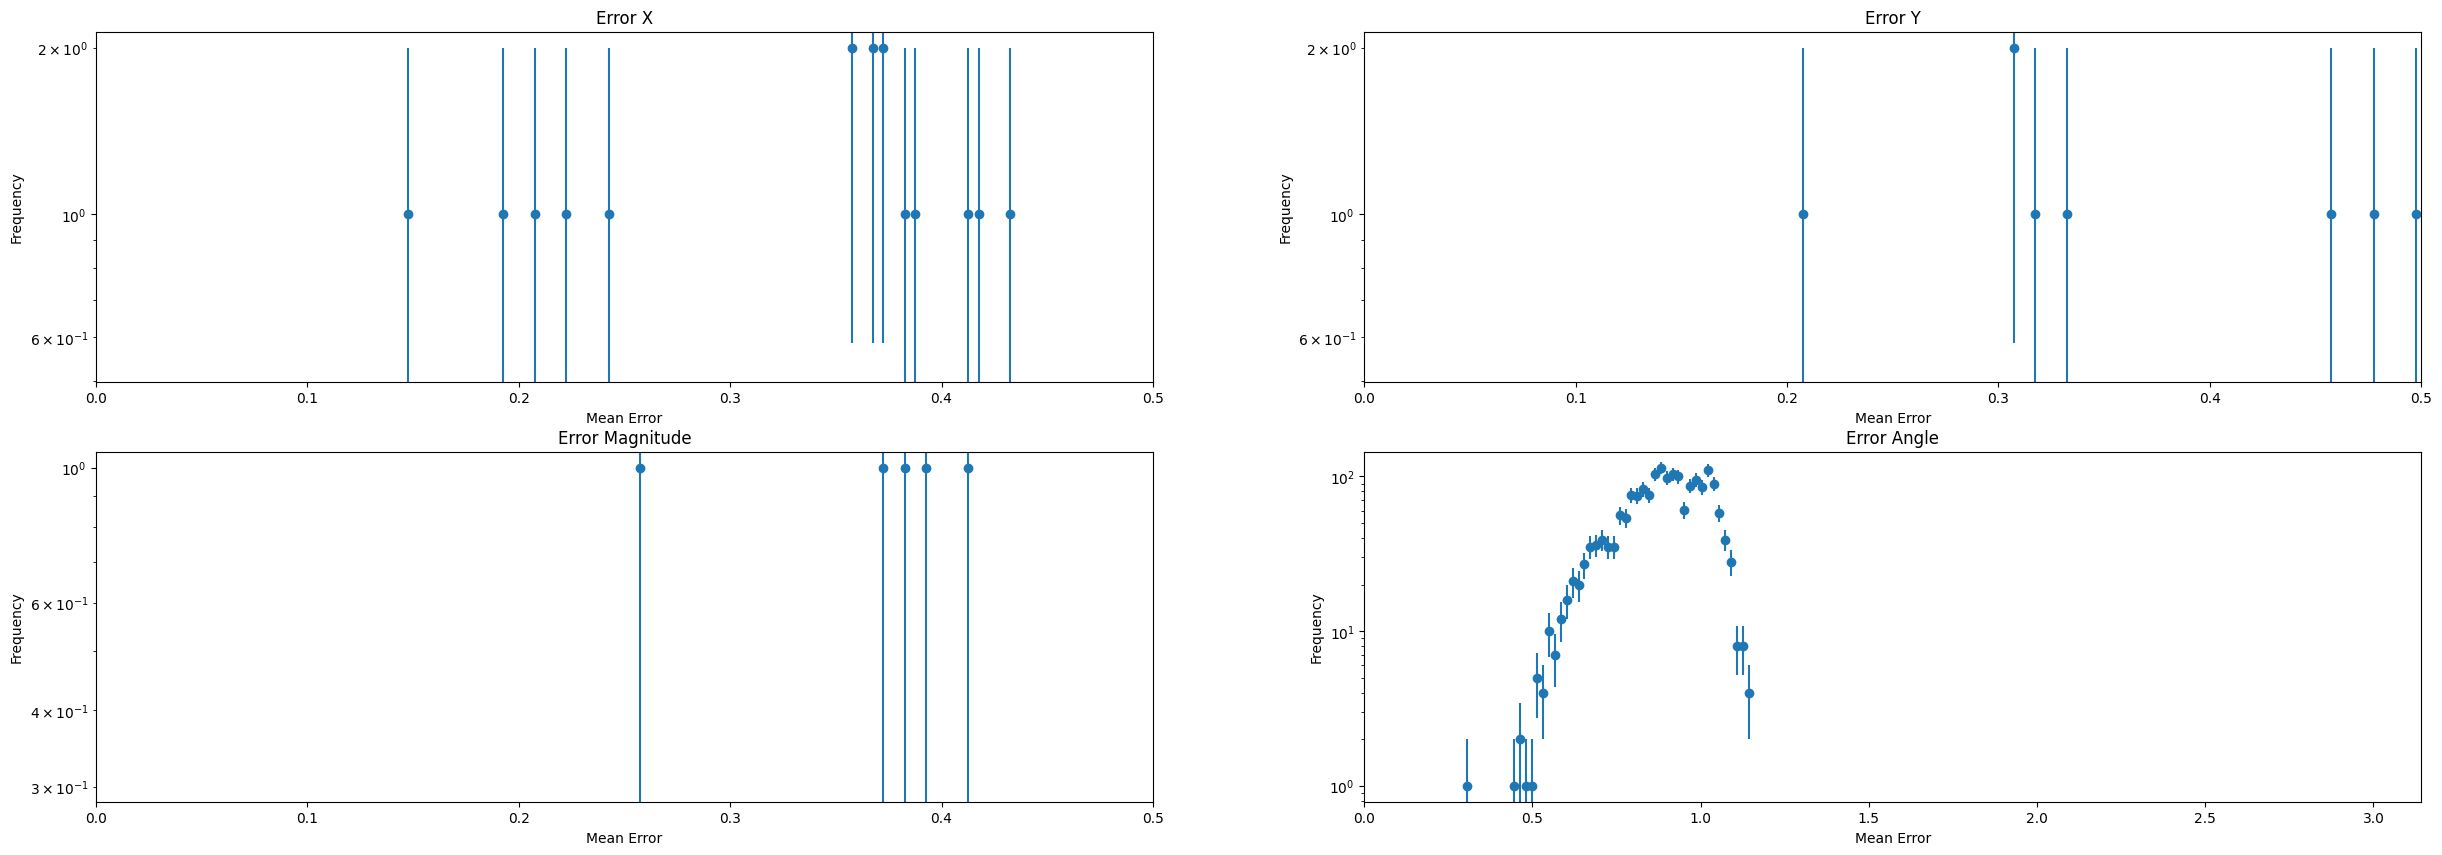

Mean error x: 2.09630773189522
Mean error y: 2.191664179130679
Mean error magnitude: 3.0556178532895593
Mean error angle: 0.8814019948953674
Mean error x std: 0.45534850615161615
Mean error y std: 0.44287547882081574
Mean error magnitude std: 0.6363371963878455
Mean error angle std: 0.12994192214602854


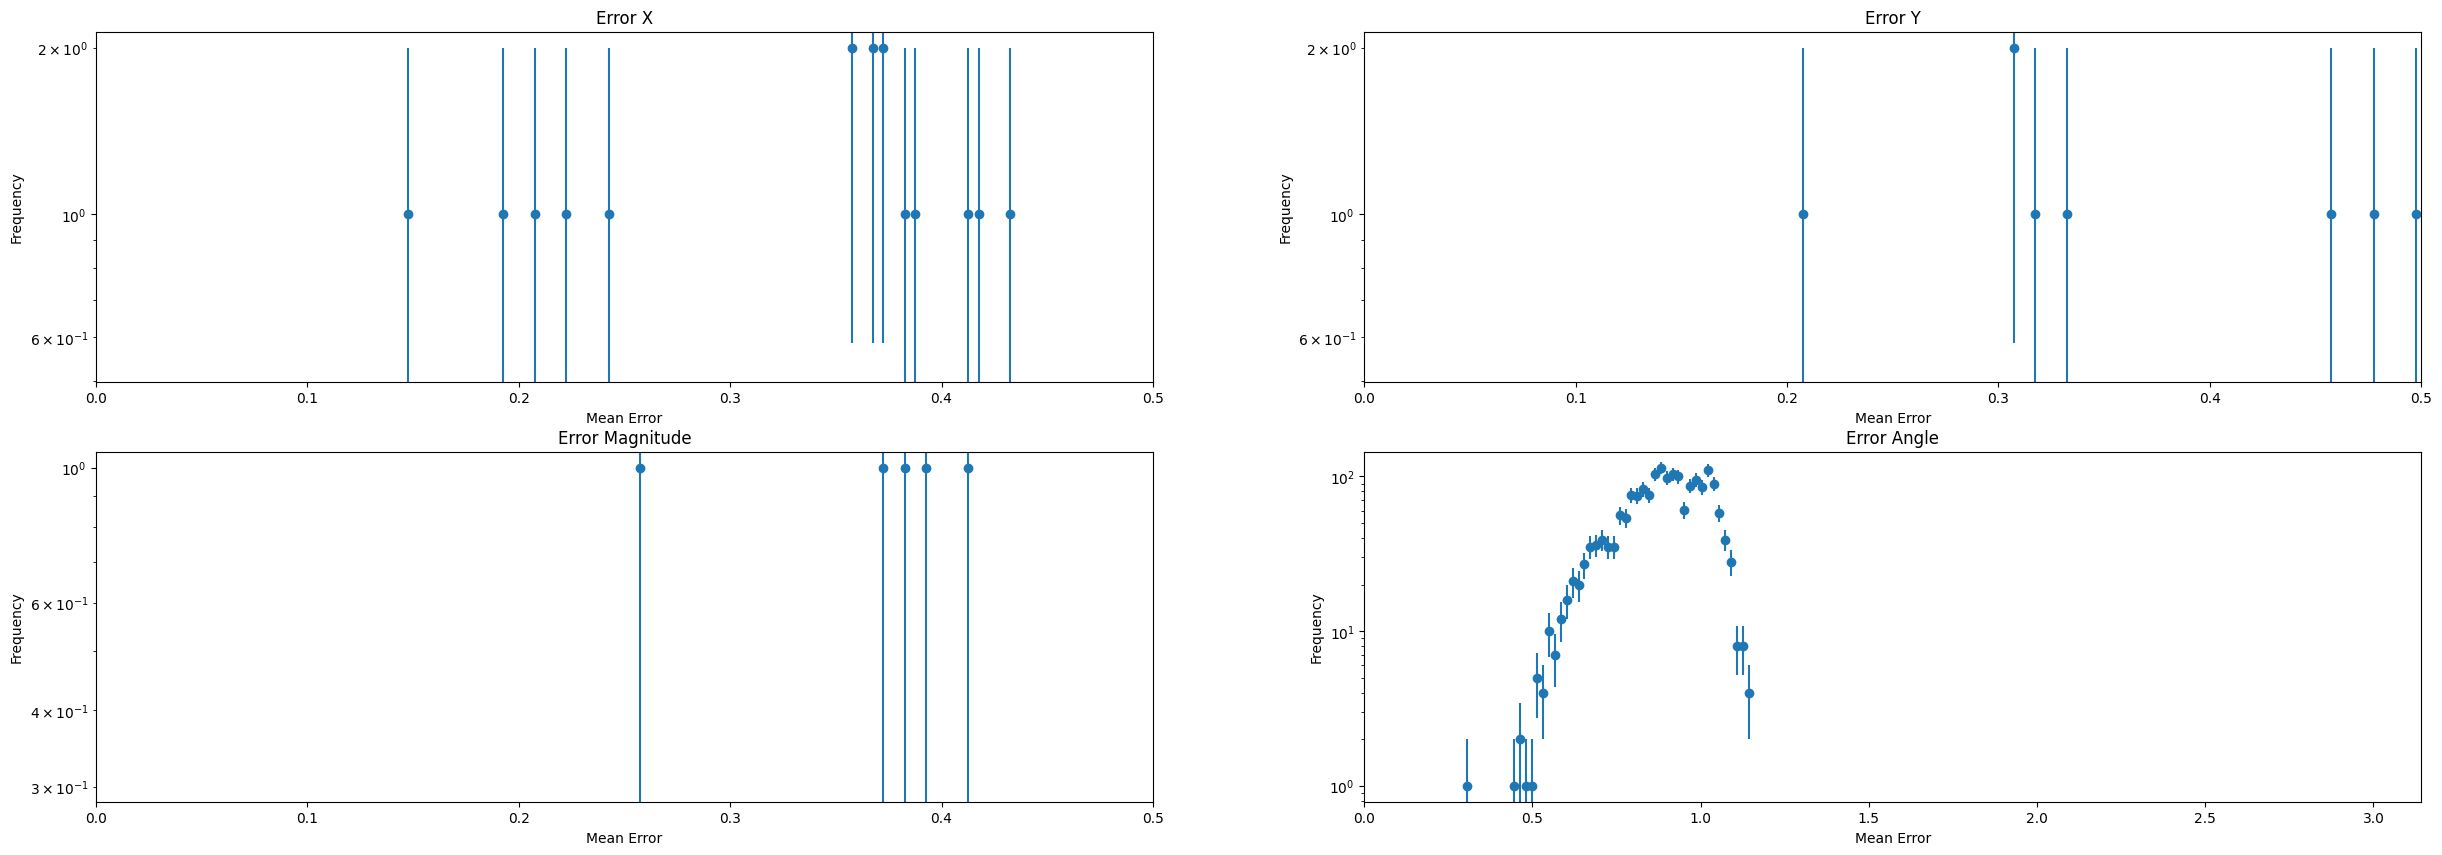

Mean error x: 2.09630773189522
Mean error y: 2.191664179130679
Mean error magnitude: 3.0556178532895593
Mean error angle: 0.8814019948953674
Mean error x std: 0.45534850615161615
Mean error y std: 0.44287547882081574
Mean error magnitude std: 0.6363371963878455
Mean error angle std: 0.12994192214602854


In [8]:
getErrorHistograms(model, test_loader, figureOfMerit="aperture")
getErrorHistograms(model, test_loader, figureOfMerit="magnet")
# getErrorHistograms(model, test_loader, figureOfMerit="outer")
# getErrorHistograms(model, test_loader, figureOfMerit="all")

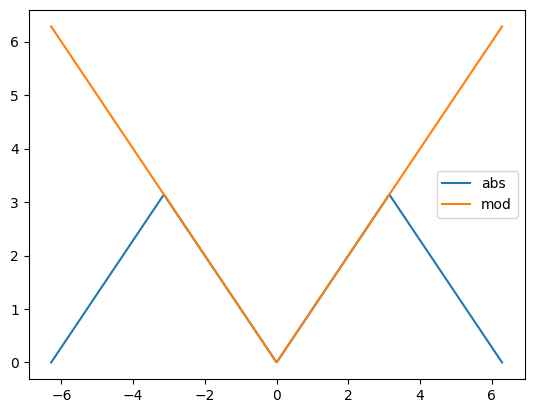

In [9]:
x = np.linspace(-2*np.pi, 2*np.pi, 628)
# get distance to any multiple of pi from any direction
y1 = abs((x + np.pi) % (2*np.pi) - np.pi)
# change to degree
y3 = np.abs(x)

plt.plot(x, y1, label="abs")
# plt.plot(x, y2, label="deg")
plt.plot(x, y3, label="mod")
plt.legend()
plt.show()

In [10]:
# load errors.pkl into a dictionary
with open("../errors.pkl", "rb") as f:
    error_dict = pickle.load(f)
print(error_dict.keys())
print(error_dict["aperture"].keys())
print(len(error_dict["aperture"]["x"]))

dict_keys(['aperture', 'magnet', 'outer'])
dict_keys(['x', 'y', 'mag', 'ang'])
66


aperture
Mean error x: 2.099520399570465
Mean error y: 2.1953653504593036
Mean error magnitude: 3.060611666767371
Mean error angle: 0.8852507207649095
Mean error x std: 0.46914292131225405
Mean error y std: 0.45502320083872133
Mean error magnitude std: 0.6540246782194338
Mean error angle std: 0.1330755260587568


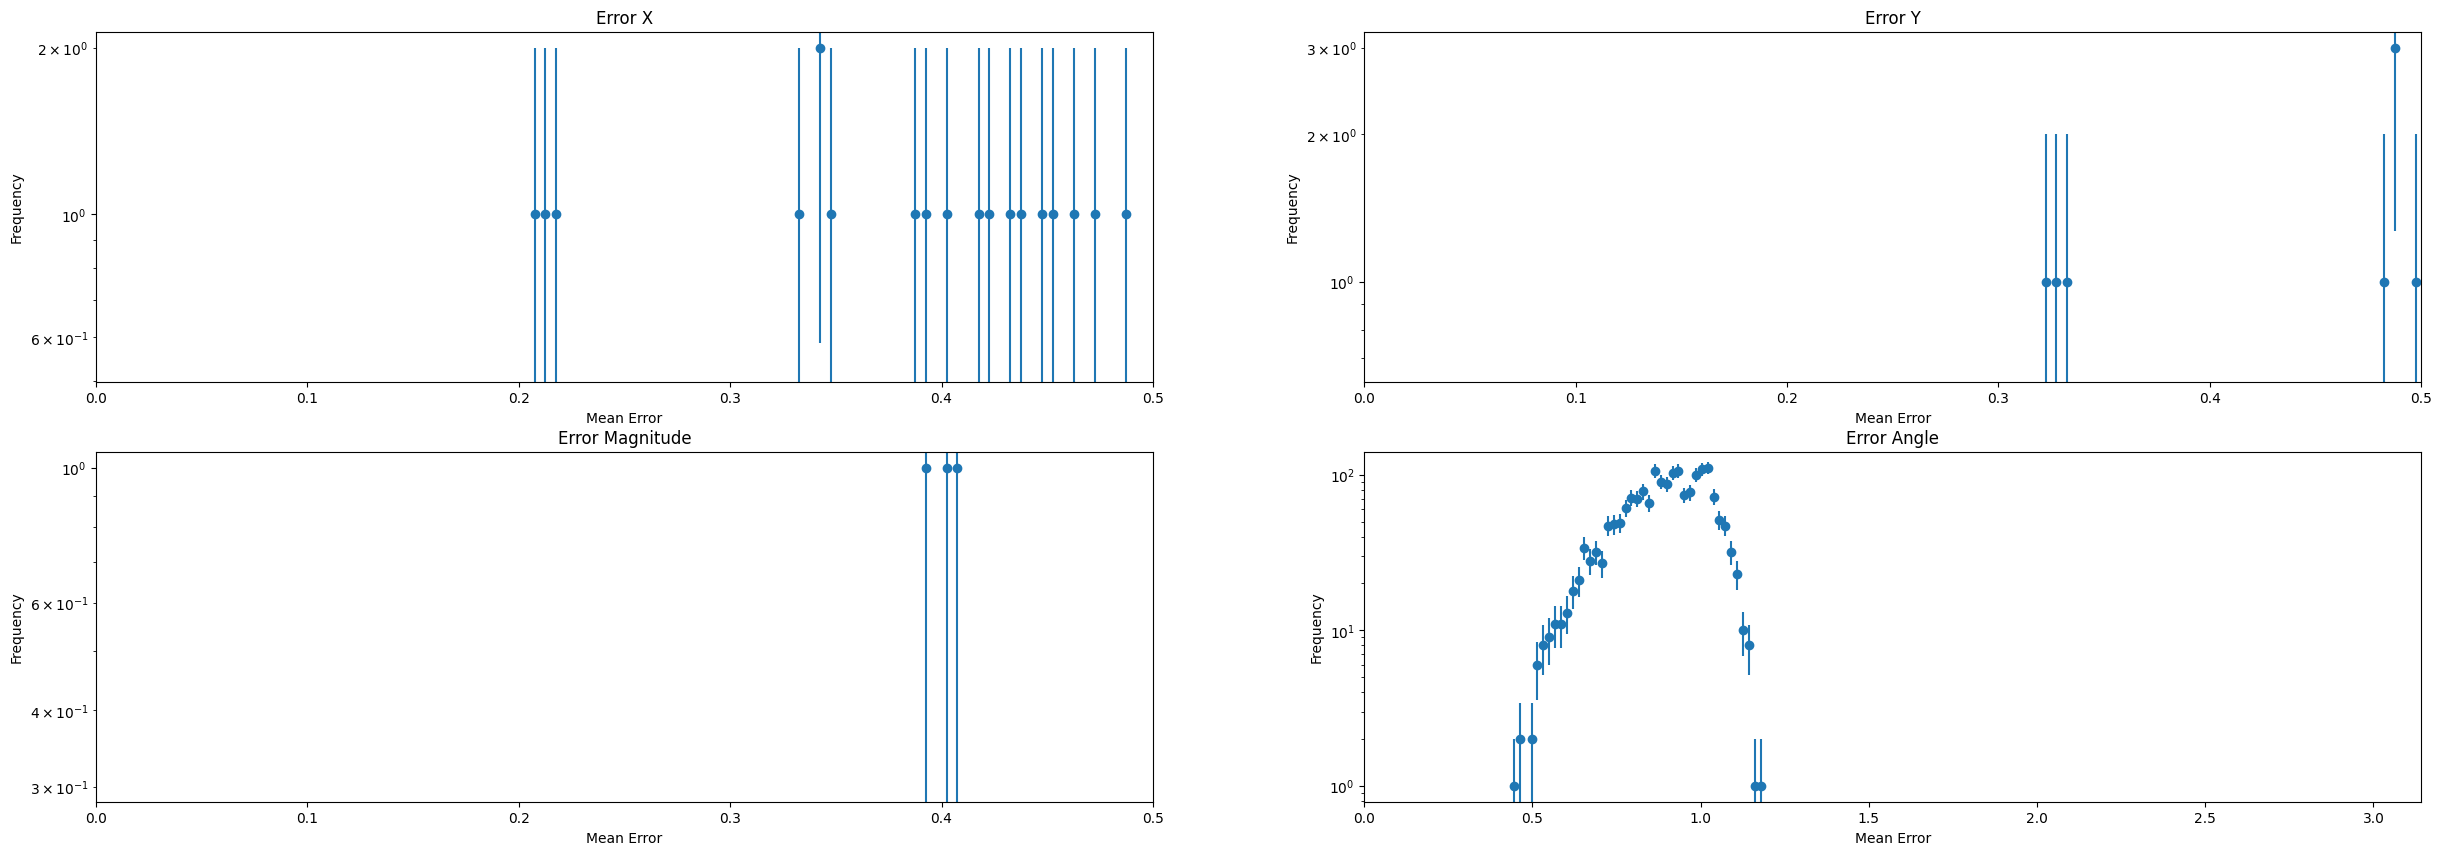

magnet
Mean error x: 2.099520399570465
Mean error y: 2.1953653504593036
Mean error magnitude: 3.060611666767371
Mean error angle: 0.8852507207649095
Mean error x std: 0.46914292131225405
Mean error y std: 0.45502320083872133
Mean error magnitude std: 0.6540246782194338
Mean error angle std: 0.1330755260587568


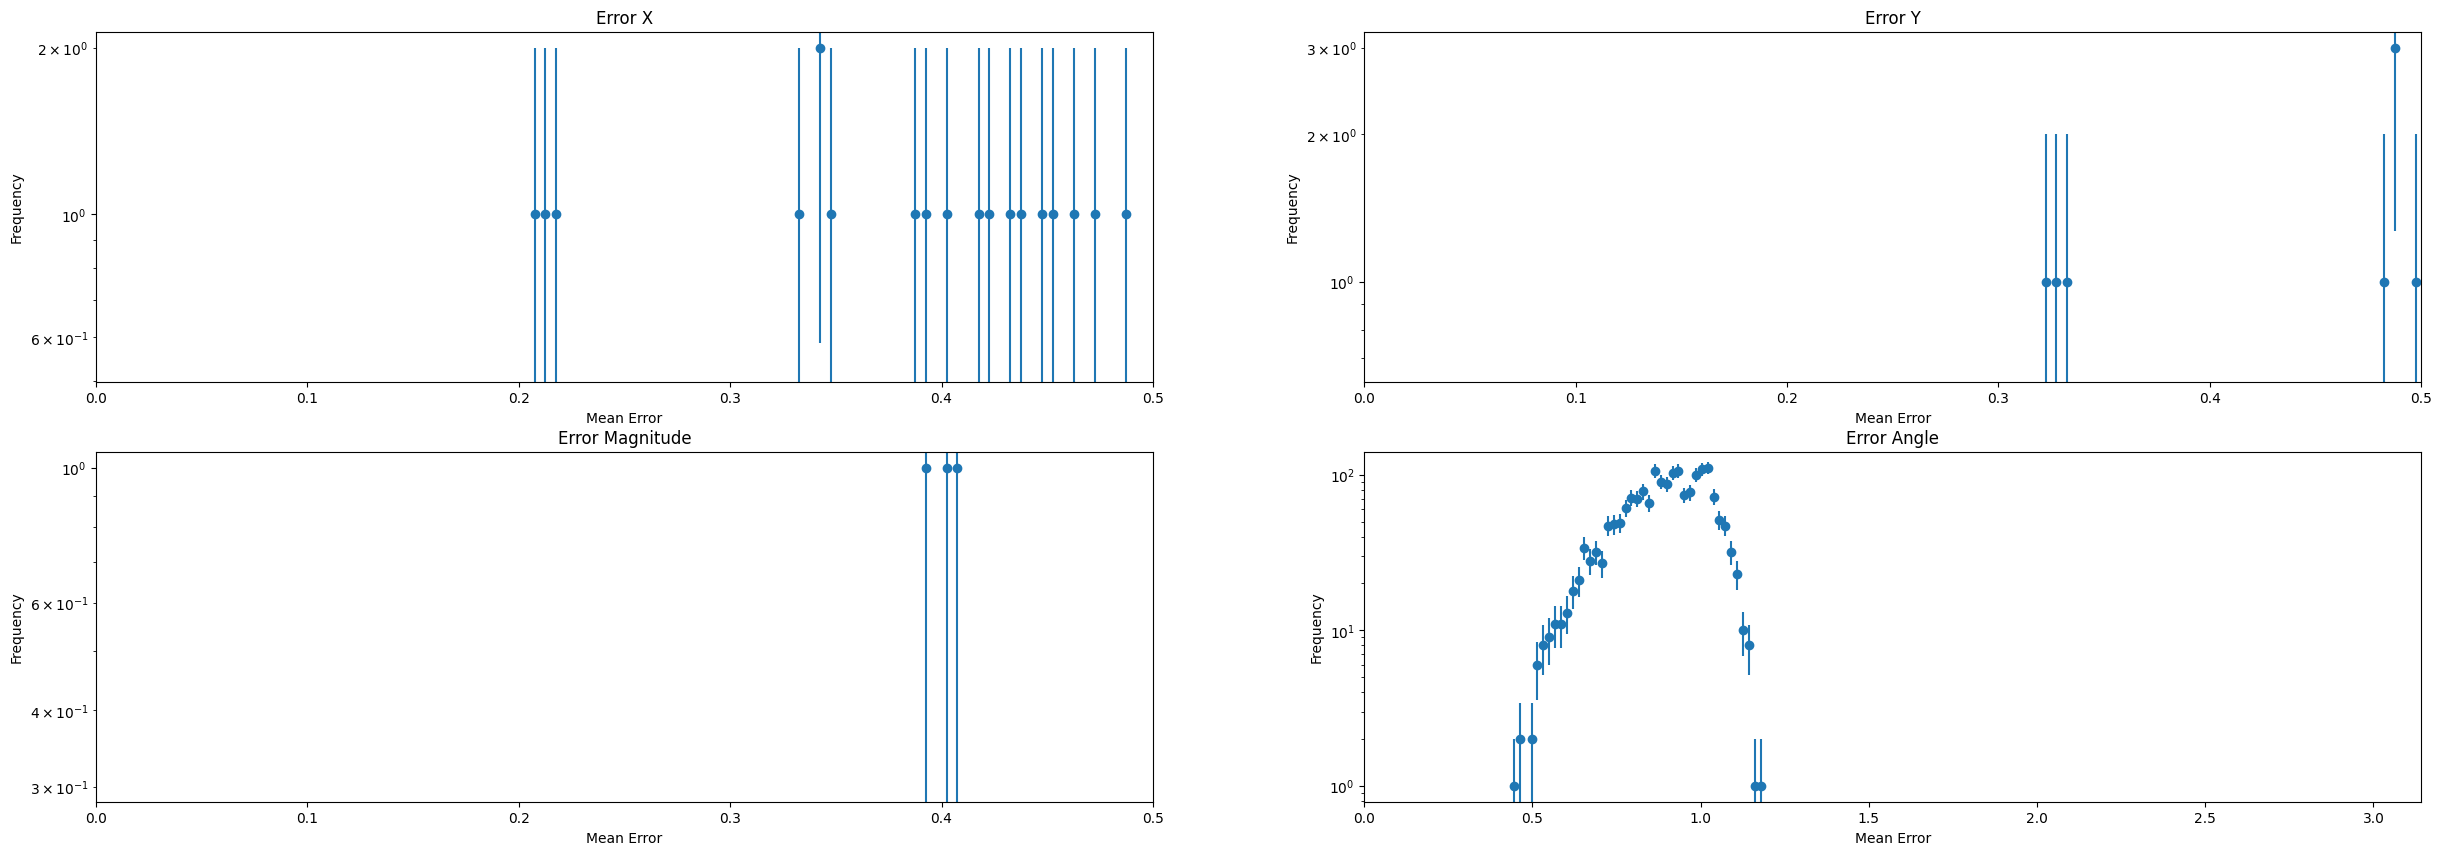

outer
Mean error x: 2.099520399570465
Mean error y: 2.1953653504593036
Mean error magnitude: 3.060611666767371
Mean error angle: 0.8852507207649095
Mean error x std: 0.46914292131225405
Mean error y std: 0.45502320083872133
Mean error magnitude std: 0.6540246782194338
Mean error angle std: 0.1330755260587568


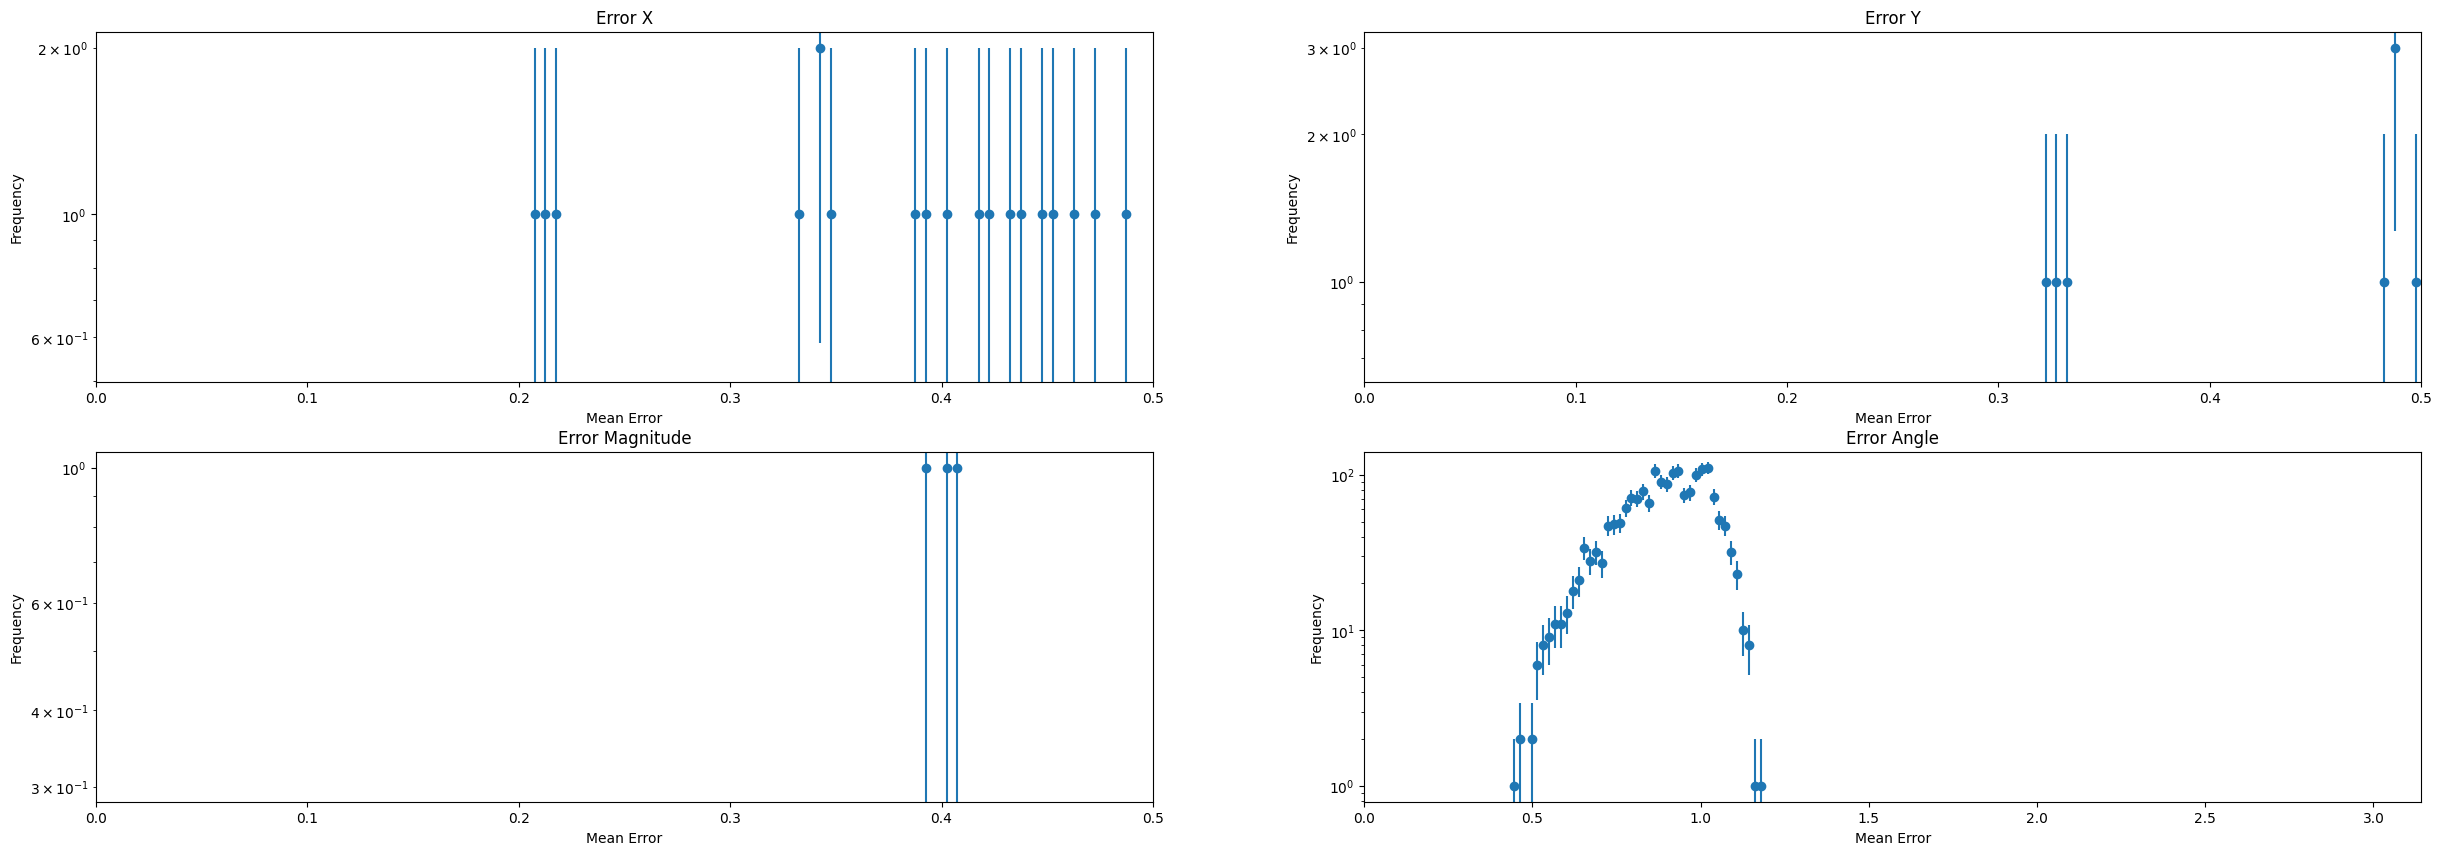

In [11]:
#plot the aperture errors
key = "aperture"
i = -1
if True:
# for i in range(len(error_dict["aperture"]["x"])):
    for key in error_dict.keys():
        error_x = error_dict[key]["x"][i]
        error_y = error_dict[key]["y"][i]
        error_mag = error_dict[key]["mag"][i]
        error_ang = error_dict[key]["ang"][i]
        print(key)
        print("Mean error x:", np.mean(error_x))
        print("Mean error y:", np.mean(error_y))
        print("Mean error magnitude:", np.mean(error_mag))
        print("Mean error angle:", np.mean(error_ang))
        print("Mean error x std:", np.std(error_x))
        print("Mean error y std:", np.std(error_y))
        print("Mean error magnitude std:", np.std(error_mag))
        print("Mean error angle std:", np.std(error_ang))
        plot_histograms(error_x, error_y, error_mag, error_ang)

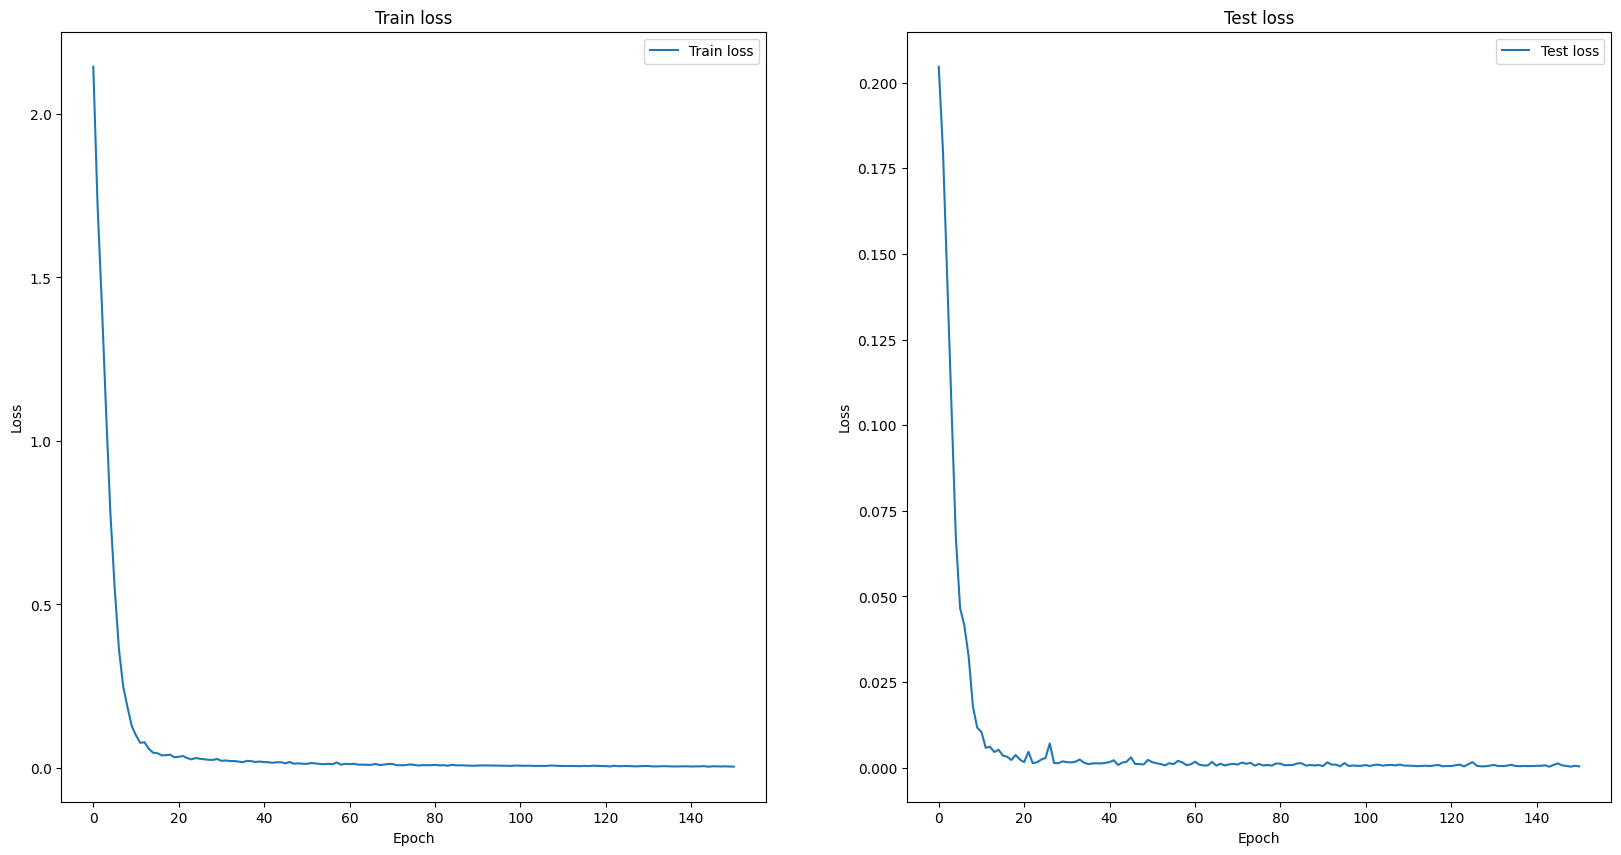

In [12]:
# load train_hist.pkl and test_hist.pkl and plot the loss
with open("../train_hist.pkl", "rb") as f:
    train_hist = pickle.load(f)
with open("../test_hist.pkl", "rb") as f:
    test_hist = pickle.load(f)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(train_hist, label="Train loss")
ax[0].set_title("Train loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[1].plot(test_hist, label="Test loss")
ax[1].set_title("Test loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend()
plt.show()
